In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score

import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor


In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")


# EDA

In [3]:
def plot_distributions(train, test, columns_to_plot):
    num_cols = 3
    num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
    
    for i, col in enumerate(columns_to_plot):
        row = i // num_cols
        col_num = i % num_cols
        ax = axes[row, col_num]
        
        sns.histplot(train[col], label='Train', color='blue', kde=True, bins=30, alpha=0.6, ax=ax)
        sns.histplot(test[col], label='Test', color='red', kde=True, bins=30, alpha=0.6, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df, title):
    correlation_matrix = df.select_dtypes(include=[np.number]).corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f"Correlation Matrix - {title}")
    plt.show()

def plot_feature_vs_target(train, features):
    train_sample = train.sample(n=1000, random_state=42)
    
    num_cols = 3
    num_rows = (len(features) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
    
    for i, feature in enumerate(features):
        row = i // num_cols
        col_num = i % num_cols
        ax = axes[row, col_num]
        
        sns.scatterplot(data=train_sample, x=feature, y='Calories', hue='Sex', alpha=0.6, ax=ax)
        ax.set_title(f'{feature} vs Calories')
    
    plt.tight_layout()
    plt.show()

# fEATURE eNGİNEERİNG

In [4]:
def feature_engineering(df):
    df = df.copy()
    
    # BMI hesaplama
    df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)
    
    # Maximum kalp atış hızı
    df['Max_HR'] = 220 - df['Age']
    
    # Yoğunluk yüzdesi
    df['Intensity_Percent'] = (df['Heart_Rate'] / df['Max_HR']) * 100
    
    # Egzersiz eforu
    df['Exercise_Effort'] = df['Duration'] * df['Heart_Rate']
    
    # Kilo/Boy oranı
    df['Weight_Height_Ratio'] = df['Weight'] / df['Height']
    
    # Cinsiyet kodlama
    if 'Sex' in df.columns:
        df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
    
    return df


In [11]:
def train_lgbm_with_kfold(X, y, X_test, n_splits=5, n_repeats=3):
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    predictions = np.zeros(len(X_test))
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"Fold {fold + 1}/{n_splits * n_repeats}")
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = lgb.LGBMRegressor(
            learning_rate=0.03,
            n_estimators=2000,
            num_leaves=31,
            subsample=0.9,
            colsample_bytree=0.7,
            random_state=42
        )
        
        # early_stopping_rounds yerine callbacks kullanımı
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=50), 
                      lgb.log_evaluation(period=100)],
        )
        
        val_pred = model.predict(X_val)
        fold_score = np.sqrt(mean_squared_error(y_val, val_pred))
        scores.append(fold_score)
        
        predictions += model.predict(X_test) / (n_splits * n_repeats)
        
        print(f"Fold {fold + 1} - RMSE: {fold_score:.4f}")
    
    print(f"\nOverall CV RMSE: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    return predictions

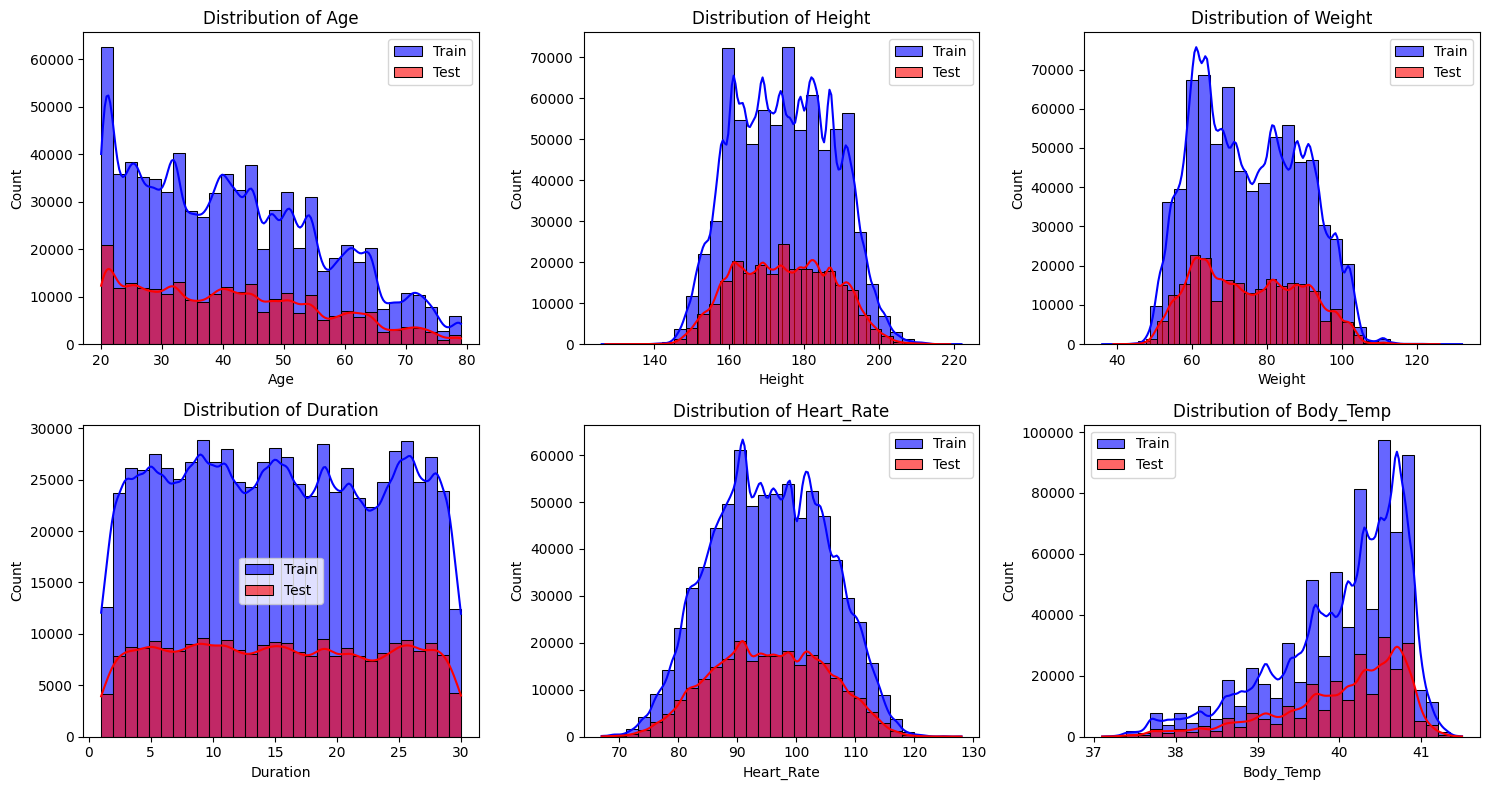

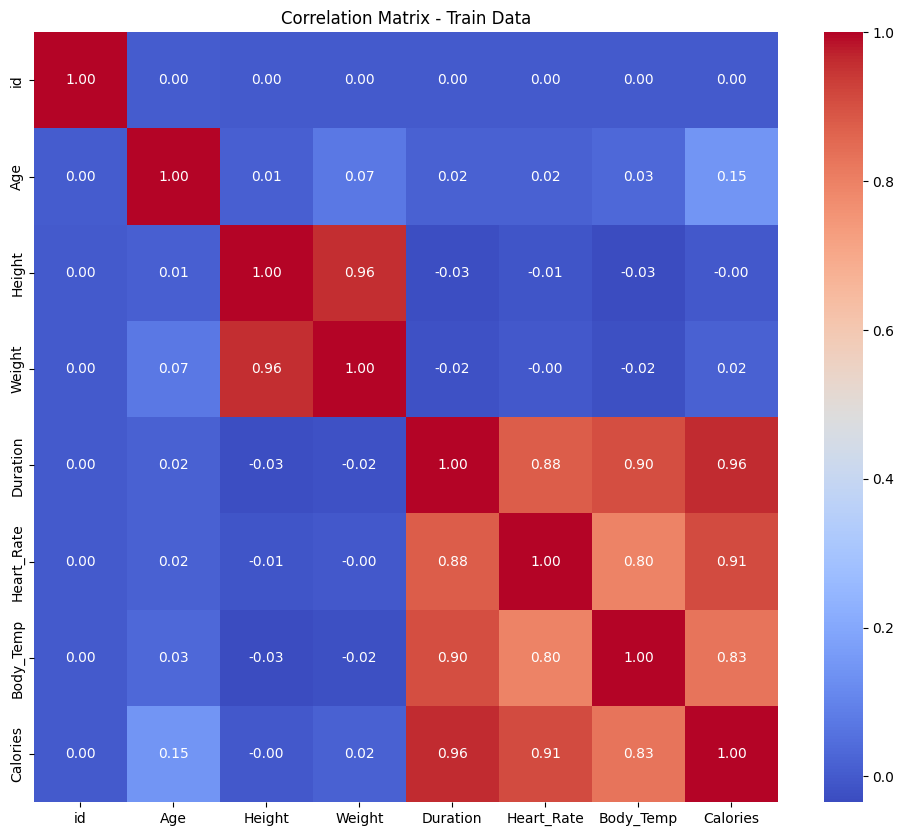

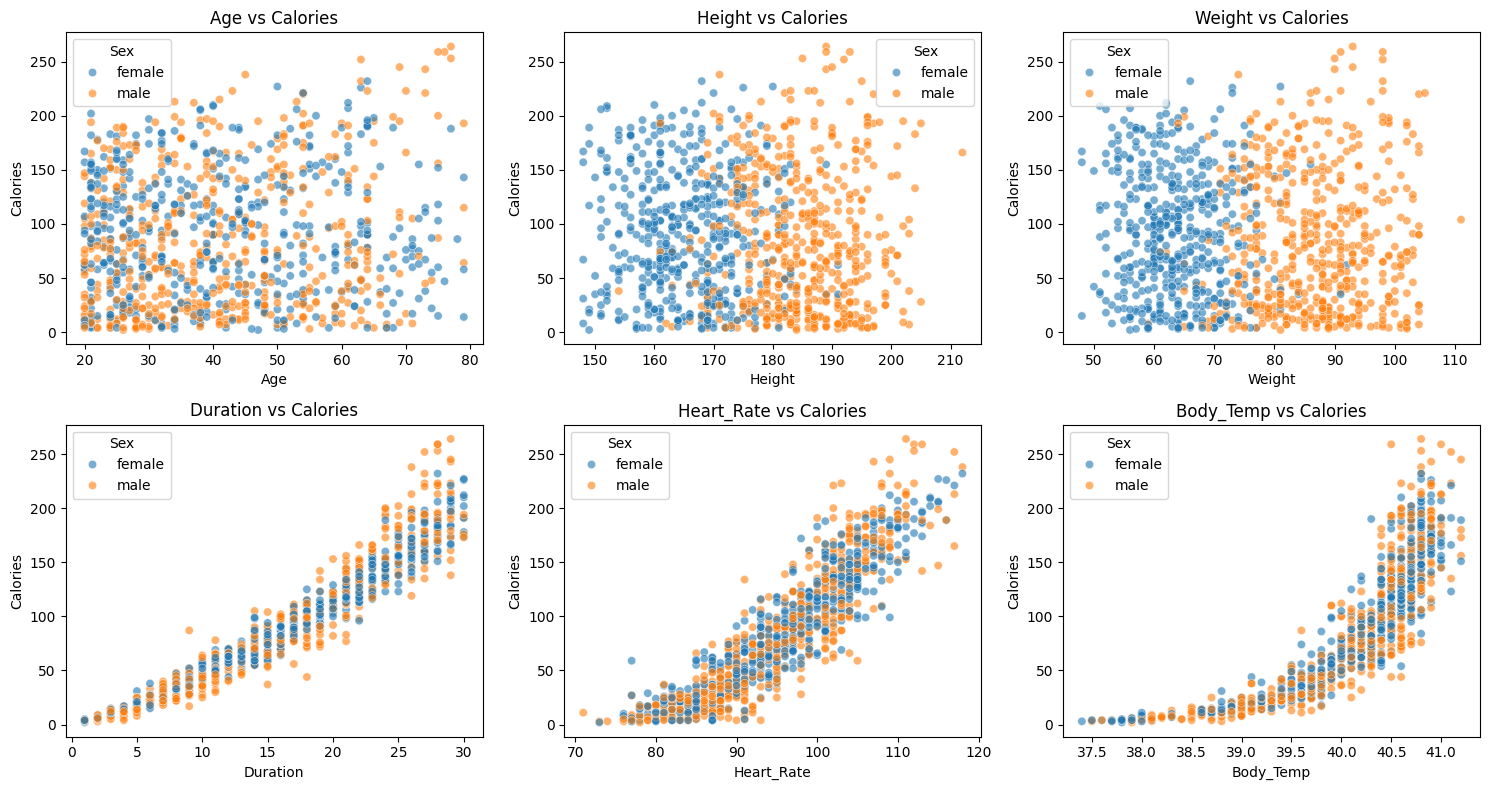

In [7]:
features_to_plot = [col for col in train.columns if col not in ['id', 'Sex', 'Calories']]
    
    # EDA
plot_distributions(train, test, features_to_plot)
plot_correlation_matrix(train, "Train Data")
plot_feature_vs_target(train, features_to_plot)
    




In [12]:
    # Özellik mühendisliği
train_processed = feature_engineering(train)
test_processed = feature_engineering(test)
    


In [13]:
    # Model için veri hazırlığı
X = train_processed.drop(['id', 'Calories'], axis=1)
y = train_processed['Calories']
X_test = test_processed.drop(['id'], axis=1)



In [14]:
    # Model eğitimi ve tahmin
predictions = train_lgbm_with_kfold(X, y, X_test)

Fold 1/15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 12
[LightGBM] [Info] Start training from score 88.298465
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 5.41289	valid_0's l2: 29.2994
[200]	valid_0's rmse: 3.74275	valid_0's l2: 14.0082
[300]	valid_0's rmse: 3.65471	valid_0's l2: 13.3569
[400]	valid_0's rmse: 3.62762	valid_0's l2: 13.1596
[500]	valid_0's rmse: 3.61406	valid_0's l2: 13.0615
[600]	valid_0's rmse: 3.60351	valid_0's l2: 12.9853
[700]	valid_0's rmse: 3.59766	valid_0's l2: 12.9432
[800]	valid_0's rmse: 3.59368	valid_0's l2: 12.9145
[900]	valid_0's rmse: 3.59015	valid_0's l2: 12.8892
Early stopping, best iteration is:
[947]	valid_0's rmse: 3.58874	valid_0's l2: 12.8791
Fold 1 - RMSE: 3.5887
Fold 2/1

In [15]:
    # Submission dosyası oluşturma
submission = pd.DataFrame({
    'id': test['id'],
    'Calories': predictions
})

submission.to_csv('lgbm_submission_v2.csv', index=False)
print("\nSubmission file created successfully!")
print("\nPrediction Statistics:")
print(f"Mean: {predictions.mean():.2f}")
print(f"Std: {predictions.std():.2f}")
print(f"Min: {predictions.min():.2f}")
print(f"Max: {predictions.max():.2f}")


Submission file created successfully!

Prediction Statistics:
Mean: 88.25
Std: 62.28
Min: 0.82
Max: 303.98
